In [ ]:
ICD9 Code and MIMIC Dataset Analysis
=======================================

-  Frequency Distribution of ICD-9 Codes in the UMLS (and MIMIC Dataset) grouped by Semantic Group
-  Frequency Distribution of ICD-9 Codes in the MIMIC Dataset: Top50 and Full versions

In [1]:
from collections import Counter
import re

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mimic_sem_info_file = "../../data/mimic3/semantic_types_mimic.txt"
icd9_sem_type_file = "../../data/ICD9_umls2020aa"
mimic_sem_groups = ['LIVB', 'PHYS', 'CONC', 'ACTI', 'CHEM', 'ANAT', 'DEVI']
sem_type_to_sem_group = dict()
icd9_to_sem_group = dict()
icd9_to_tui = dict()
tui_to_desc = dict()

In [4]:
with open(mimic_sem_info_file, mode="r") as sf:
    for line in sf:
        if line:
            sg, sg_desc, tui, st_desc = line.split("|")
            sem_type_to_sem_group[tui] = sg
            tui_to_desc[tui] = st_desc

In [5]:
with open(icd9_sem_type_file, mode="r") as icdf:
    for line in icdf:
        if line:
            icd9, cui, tui, desc = line.split("\t")
            try:
                icd9_to_tui[icd9] = tui
                icd9_to_sem_group[icd9] = sem_type_to_sem_group[tui]
            except KeyError:
                if "T019" or "T047" in tui:  # these 2 TUI belong to the same SEM GROUP
                    icd9_to_sem_group[icd9] = sem_type_to_sem_group["T019"]
                else:
                    print(f"{icd9}:{tui} not in MIMIC, skipping...")
                    continue
            
            icd9_sg = icd9_to_sem_group.get(icd9, "N/A")
            if icd9_sg in mimic_sem_groups:
                print(f"{icd9}:{desc} -- {icd9_sg}:{tui}:{tui_to_desc.get(tui, 'N/A')}")

03.92:Injections, Spinal
 -- CONC:T169:Functional Concept

302.3:Transvestism
 -- PHYS:T032:Organism Attribute

302.50:Trans-sexualism with unspecified sexual history
 -- PHYS:T032:Organism Attribute

302.51:Trans-sexualism with asexual history
 -- PHYS:T032:Organism Attribute

302.52:Trans-sexualism with homosexual history
 -- PHYS:T032:Organism Attribute

302.53:Trans-sexualism with heterosexual history
 -- PHYS:T032:Organism Attribute

574.51:Calculus of bile duct with cholecystitis, without mention of obstruction
 -- ANAT:T031:Body Substance

650-659.99:NORMAL DELIVERY, AND OTHER INDICATIONS FOR CARE IN PREGNANCY, LABOR, AND DELIVERY
 -- PHYS:T040:Organism Function

651.80:Other specified multiple gestation, unspecified as to episode of care or not applicable
 -- PHYS:T040:Organism Function

651.81:Other specified multiple gestation, delivered, with or without mention of antepartum condition
 -- PHYS:T040:Organism Function

659.50:Elderly primigravida, unspecified as to episode of 

In [6]:
icd9_sg_counter = Counter(icd9_to_sem_group.values())
icd9_sg_counter

Counter({'PROC': 4579,
         'DISO': 16129,
         'CONC': 4,
         'PHYS': 11,
         'ANAT': 1,
         'PHEN': 390,
         'LIVB': 26,
         'ACTI': 3,
         'CHEM': 3,
         'DEVI': 1})

## MIMIC Dataset Distributions

In [7]:
import sys
sys.path.append('..')
from src.utils.corpus_readers import MimicDocIter

/Users/noonscape/opt/anaconda3/envs/mrcnnpy38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
top50_train_file = "../../data/mimic3/50/train_50.csv"
top50_dev_file = "../../data/mimic3/50/dev_50.csv"
top50_test_file = "../../data/mimic3/50/test_50.csv"

full_train_file = "../../data/mimic3/full/train_full.csv"
full_dev_file = "../../data/mimic3/full/dev_full.csv"
full_test_file = "../../data/mimic3/full/test_full.csv"

In [9]:
top50_tr_labels = MimicDocIter(top50_train_file, 3)
top50_dev_labels = MimicDocIter(top50_dev_file, 3)
top50_test_labels = MimicDocIter(top50_test_file, 3)

full_tr_labels = MimicDocIter(full_train_file, 3)
full_dev_labels = MimicDocIter(full_dev_file, 3)
full_test_labels = MimicDocIter(full_test_file, 3)

In [10]:
mis_typed_ic9_pattern = re.compile("^\d+\.$")  # filter out mistyped ICD9 codes e.g. 11. for 11.0

def get_sem_group_freq(labels_iter, icd9_to_sg_mapping):
    sem_group_counter = Counter()
    no_umls_coverage = Counter()
    for labels in labels_iter:         
        sem_groups = []
        for icd9 in labels:
            try:
                sg = icd9_to_sg_mapping[icd9]
            except KeyError:
                if mis_typed_ic9_pattern.match(icd9):
                    icd9 = f"{icd9}0"
                else:
                    no_umls_coverage.update([icd9])
                    continue
                try:
                    sg = icd9_to_sg_mapping[icd9]
                except KeyError:
                    print(f"{icd9} not in UMLS for real!!")
                    no_umls_coverage.update([icd9])
                    continue
            sem_groups.append(sg)
        sem_group_counter.update(sem_groups)
    return sem_group_counter, no_umls_coverage

In [11]:
top50_tr_sg, top50_tr_out = get_sem_group_freq(top50_tr_labels, icd9_to_sem_group)
top50_dev_sg, top50_dev_out = get_sem_group_freq(top50_dev_labels, icd9_to_sem_group)
top50_test_sg, top50_test_out = get_sem_group_freq(top50_test_labels, icd9_to_sem_group)

In [12]:
full_tr_sg, full_tr_out = get_sem_group_freq(full_tr_labels, icd9_to_sem_group)
full_dev_sg, full_dev_out = get_sem_group_freq(full_dev_labels, icd9_to_sem_group)
full_test_sg, full_test_out = get_sem_group_freq(full_test_labels, icd9_to_sem_group)

17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for

In [13]:
for sg_counter in [top50_tr_sg, top50_dev_sg, top50_test_sg]:
    print(sg_counter)

Counter({'DISO': 30077, 'PROC': 15842})
Counter({'DISO': 6849, 'PROC': 2434})
Counter({'DISO': 7831, 'PROC': 2646})


In [14]:
for out_icd9_counter in [top50_tr_out, top50_dev_out, top50_test_out]:
    print(out_icd9_counter)

Counter()
Counter()
Counter()


In [15]:
for sg_counter in [full_tr_sg, full_dev_sg, full_test_sg]:
    print(sg_counter)

Counter({'DISO': 528538, 'PROC': 209754, 'PHEN': 3551, 'LIVB': 2636, 'ANAT': 143, 'ACTI': 49, 'PHYS': 6})
Counter({'DISO': 21447, 'PROC': 6252, 'PHEN': 149, 'ANAT': 7, 'LIVB': 1, 'ACTI': 1, 'PHYS': 1})
Counter({'DISO': 45955, 'PROC': 13187, 'PHEN': 319, 'ANAT': 10, 'ACTI': 7, 'LIVB': 1})


### MIMIC ICD9 Codes without UMLS info???

In [16]:
for out_icd9_counter in [full_tr_out, full_dev_out, full_test_out]:
    print(out_icd9_counter, "\n", "Total Partition Count: ", sum(out_icd9_counter.values()), "\n")
    print("Total Partition Unique ICD9 :", len(out_icd9_counter), "\n\n")

Counter({'38.97': 1291, '36.01': 1056, 'V49.86': 993, '17.0': 814, 'V45.11': 481, '997.31': 415, '30.9': 397, '250.50': 387, '707.22': 343, 'V87.41': 307, '276.69': 270, '780.60': 225, '36.05': 220, '041.12': 191, 'V49.87': 170, 'V12.04': 157, '599.70': 155, '041.49': 152, '511.89': 145, '780.61': 145, '23.9': 141, 'V88.01': 127, '599.71': 126, '518.51': 124, '482.42': 124, '707.23': 122, 'V02.54': 122, '294.20': 119, '11.8': 113, '780.62': 112, 'V12.55': 108, '997.39': 107, '284.19': 104, '287.49': 101, '784.51': 101, '511.81': 97, '707.24': 96, '707.25': 91, '707.20': 90, '249.00': 90, '348.89': 89, '997.49': 89, '038.12': 89, '707.21': 87, '453.81': 87, '37.36': 85, '278.03': 79, '274.01': 76, 'V15.51': 74, '289.84': 73, '729.92': 71, 'V46.3': 66, 'V85.41': 63, '453.82': 61, '518.52': 58, '39.75': 50, '780.65': 49, '416.2': 44, '793.11': 43, 'V15.52': 39, 'V45.88': 39, 'V85.43': 38, '285.3': 38, 'V13.51': 35, '571.42': 34, 'V85.42': 33, '999.32': 32, '786.30': 30, '453.86': 30, '279

In [27]:
# cumulative value merge
def mergeDictionary(dict_1, dict_2):
   dict_3 = {**dict_1, **dict_2}
   for key, value in dict_3.items():
       if key in dict_1 and key in dict_2:
               dict_3[key] = int(value) + int(dict_1[key])
   return dict_3

In [29]:
# combine these counter dicts
outlier_icd9 = dict()
temp_dict = dict()
temp_dict = mergeDictionary(full_tr_out, full_dev_out)
outlier_icd9 = mergeDictionary(temp_dict, full_test_out)

In [30]:
# make a .csv file separated by \t to store these ICD-9 codes
# name it ICD9_descriptions to use the existing query script
out_icd9_filename = "ICD9_descriptions"
with open(out_icd9_filename, "a") as wf:
    for icd9 in outlier_icd9.keys():
        if icd9:
            wf.write(f"{icd9}\tDescription Placeholder\n")

## UMLS MIMIC ICD-9 Semantic Group Distribution

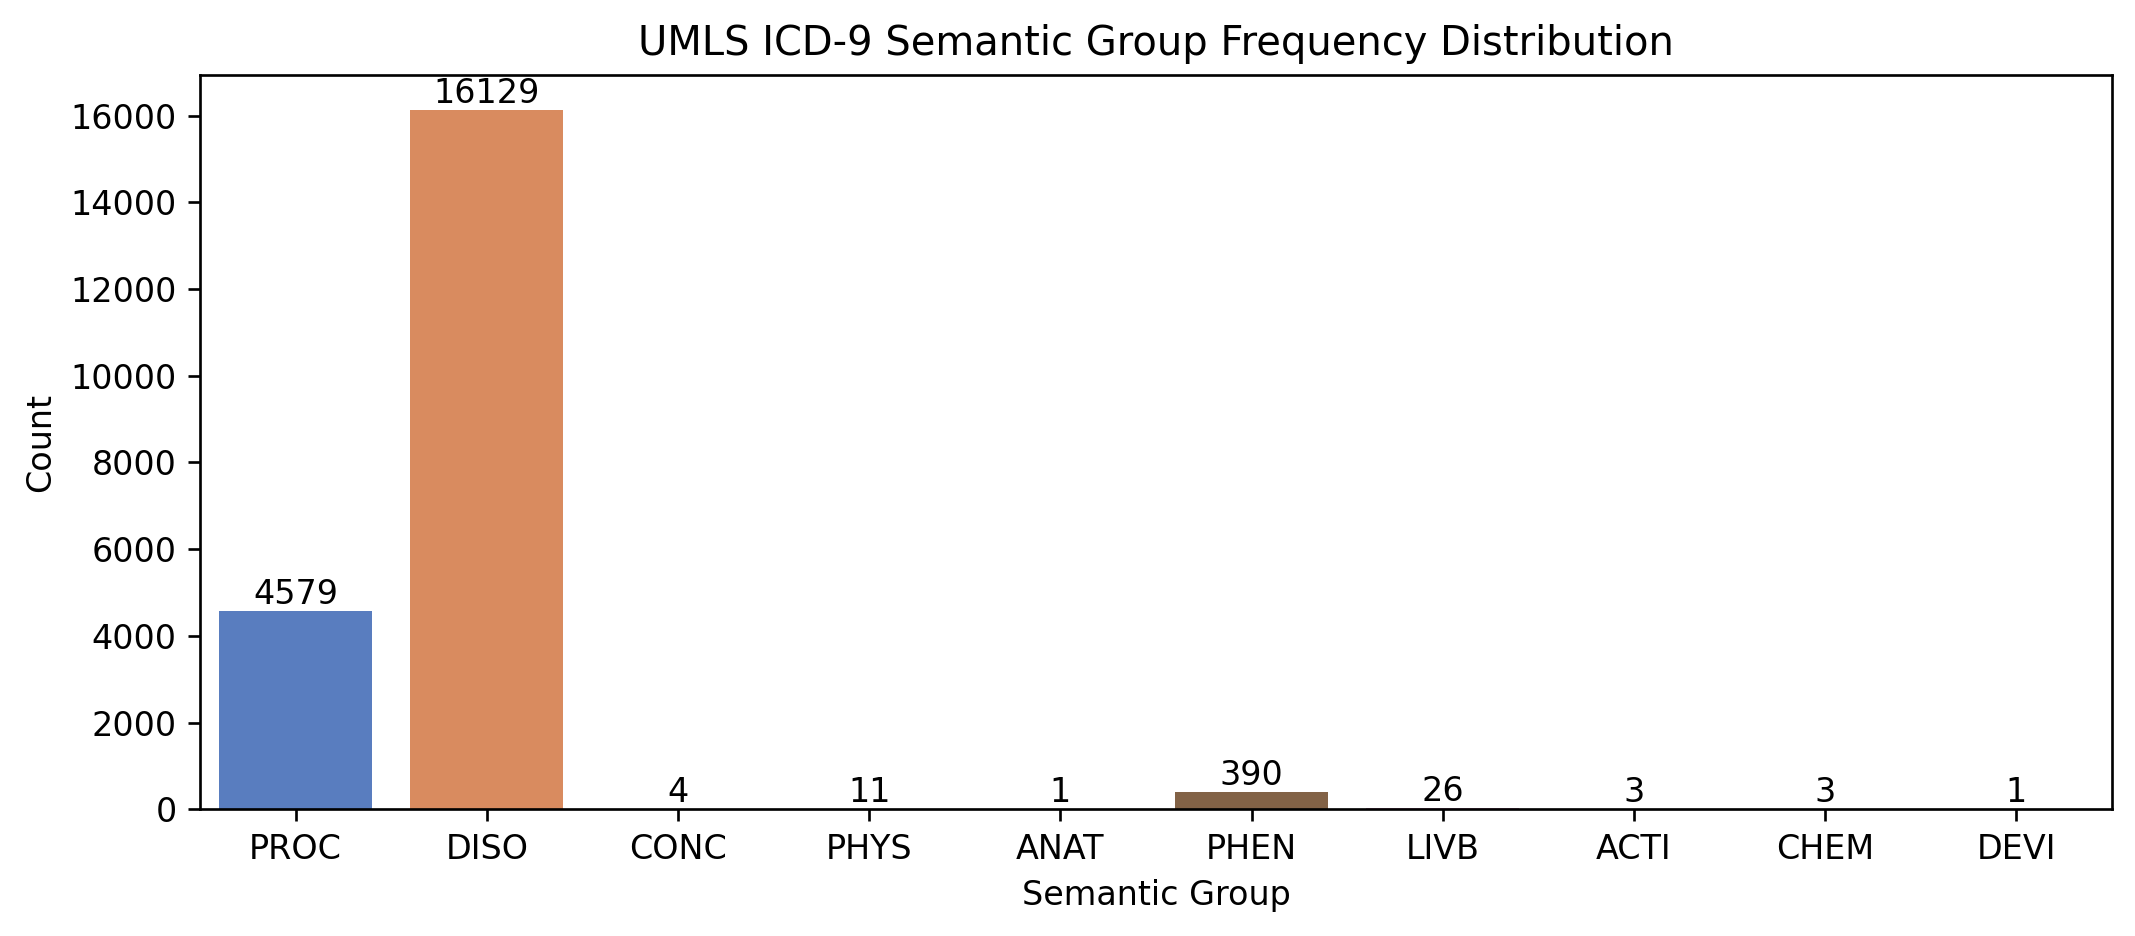

In [19]:
plt.figure(figsize=(9,4), dpi=240)
ax = sns.barplot(y=list(icd9_sg_counter.values()), x=list(icd9_sg_counter.keys()),palette="muted")
plt.xlabel(f"Semantic Group")
plt.ylabel(f"Count")
plt.title(f"UMLS ICD-9 Semantic Group Frequency Distribution")
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

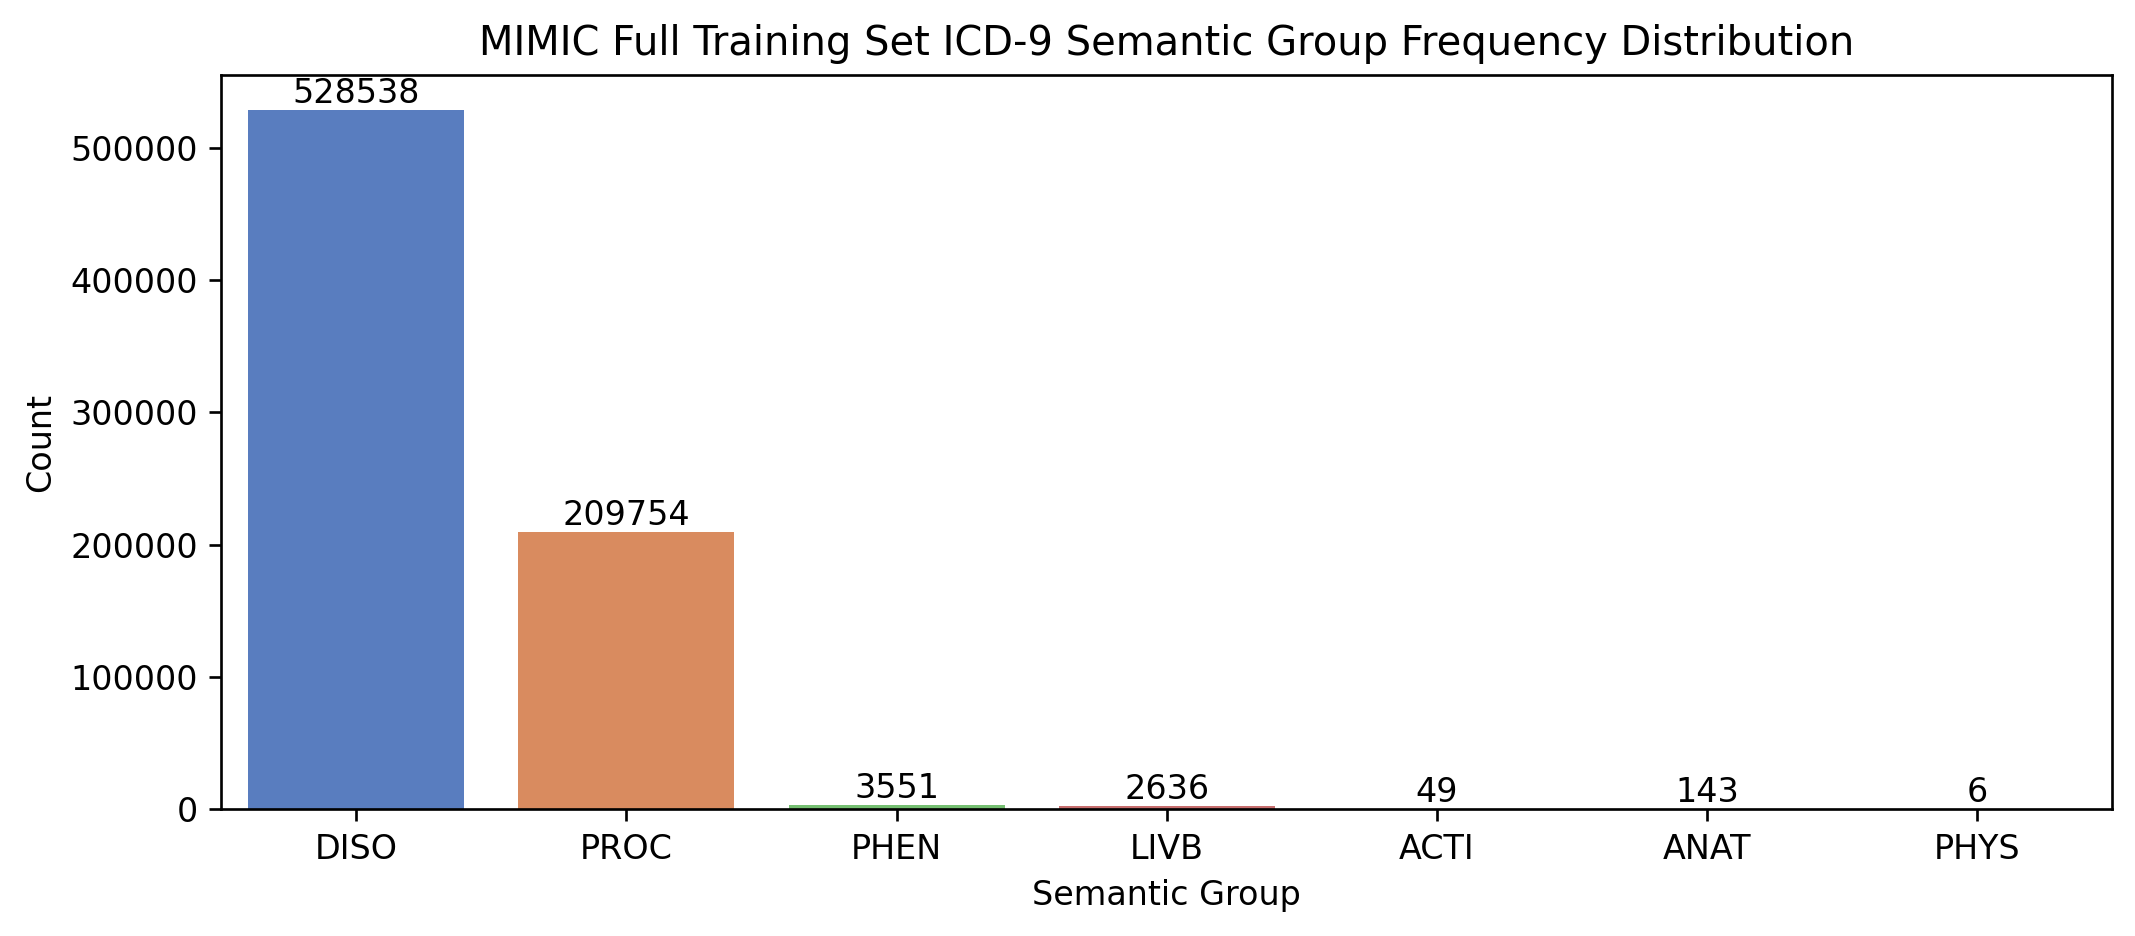

In [20]:
plt.figure(figsize=(9,4), dpi=240)
ax = sns.barplot(y=list(full_tr_sg.values()), x=list(full_tr_sg.keys()),palette="muted")
plt.xlabel(f"Semantic Group")
plt.ylabel(f"Count")
plt.title(f"MIMIC Full Training Set ICD-9 Semantic Group Frequency Distribution")
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

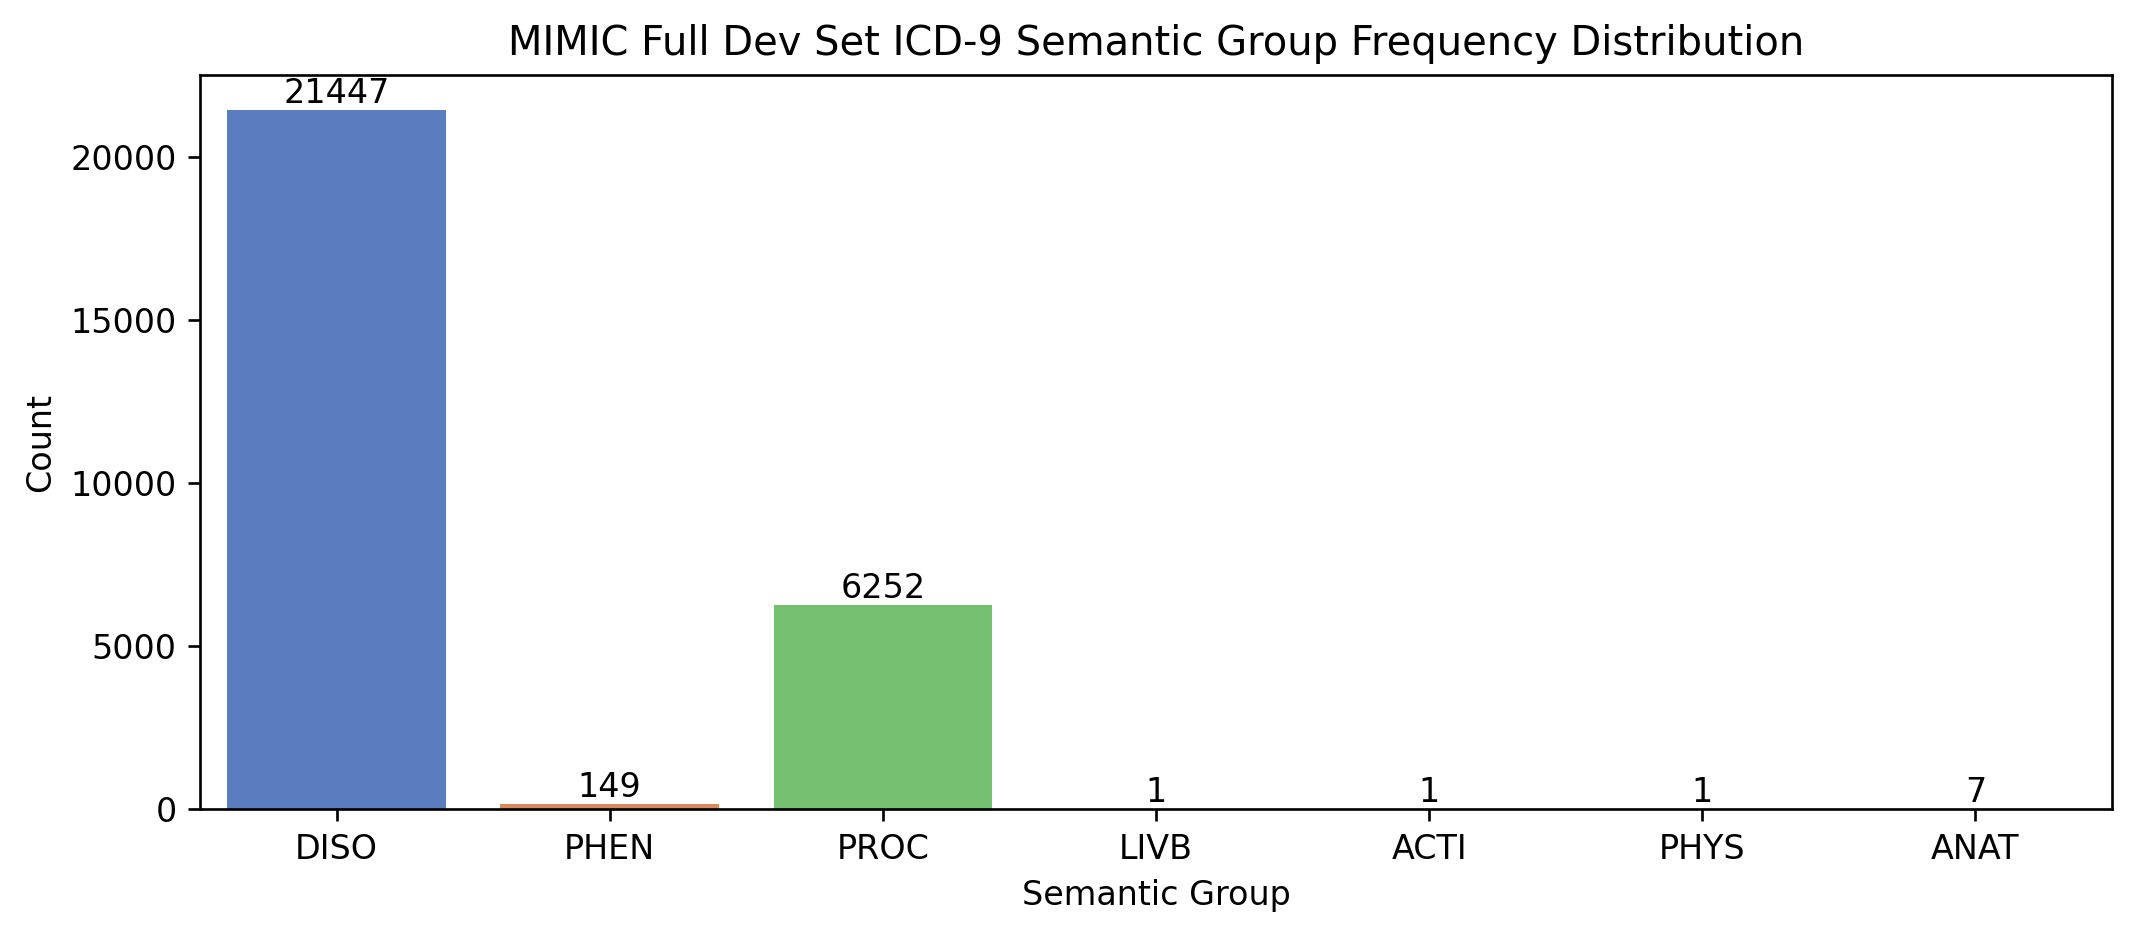

In [21]:
plt.figure(figsize=(9,4), dpi=240)
ax = sns.barplot(y=list(full_dev_sg.values()), x=list(full_dev_sg.keys()),palette="muted")
plt.xlabel(f"Semantic Group")
plt.ylabel(f"Count")
plt.title(f"MIMIC Full Dev Set ICD-9 Semantic Group Frequency Distribution")
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

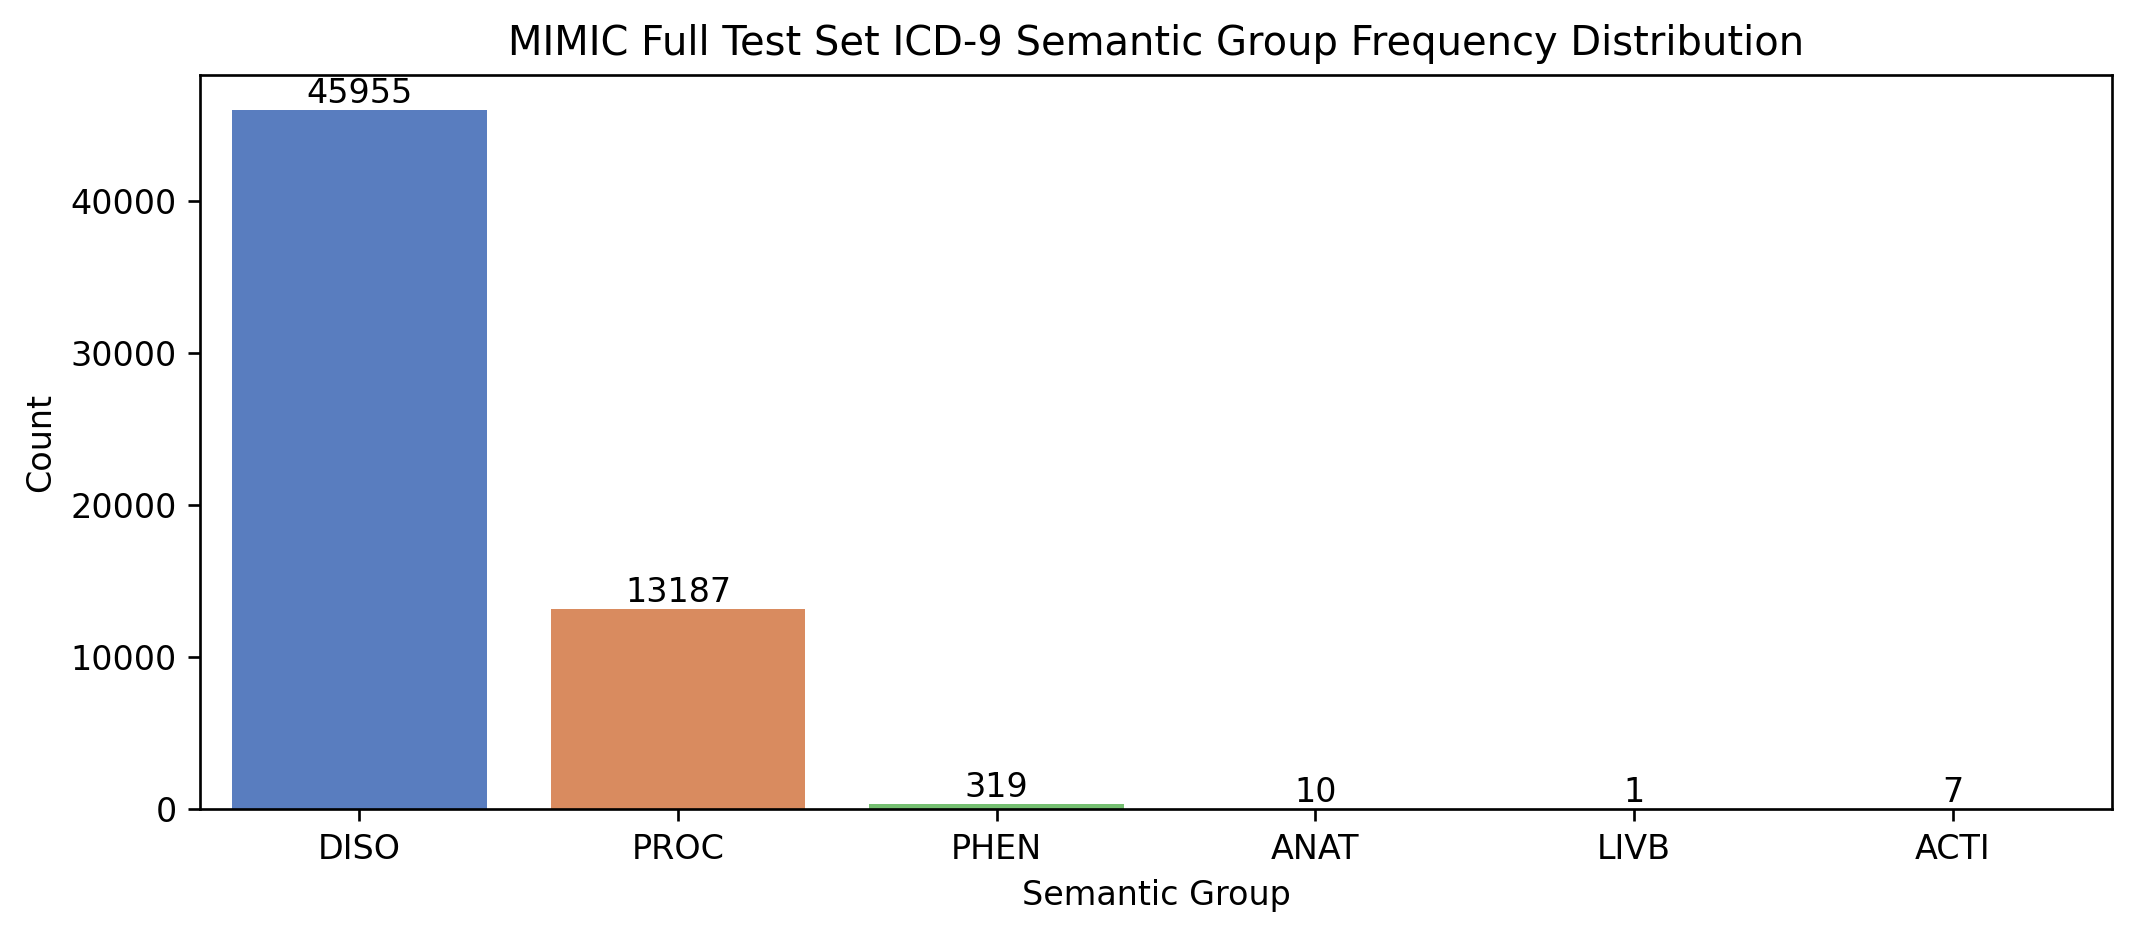

In [23]:
plt.figure(figsize=(9,4), dpi=240)
ax = sns.barplot(y=list(full_test_sg.values()), x=list(full_test_sg.keys()),palette="muted")
plt.xlabel(f"Semantic Group")
plt.ylabel(f"Count")
plt.title(f"MIMIC Full Test Set ICD-9 Semantic Group Frequency Distribution")
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

In [31]:
# full (all partition distribution)
full_all_sg = dict()
temp_sg = mergeDictionary(full_tr_sg, full_dev_sg)
full_all_sg = mergeDictionary(temp_sg, full_test_sg)

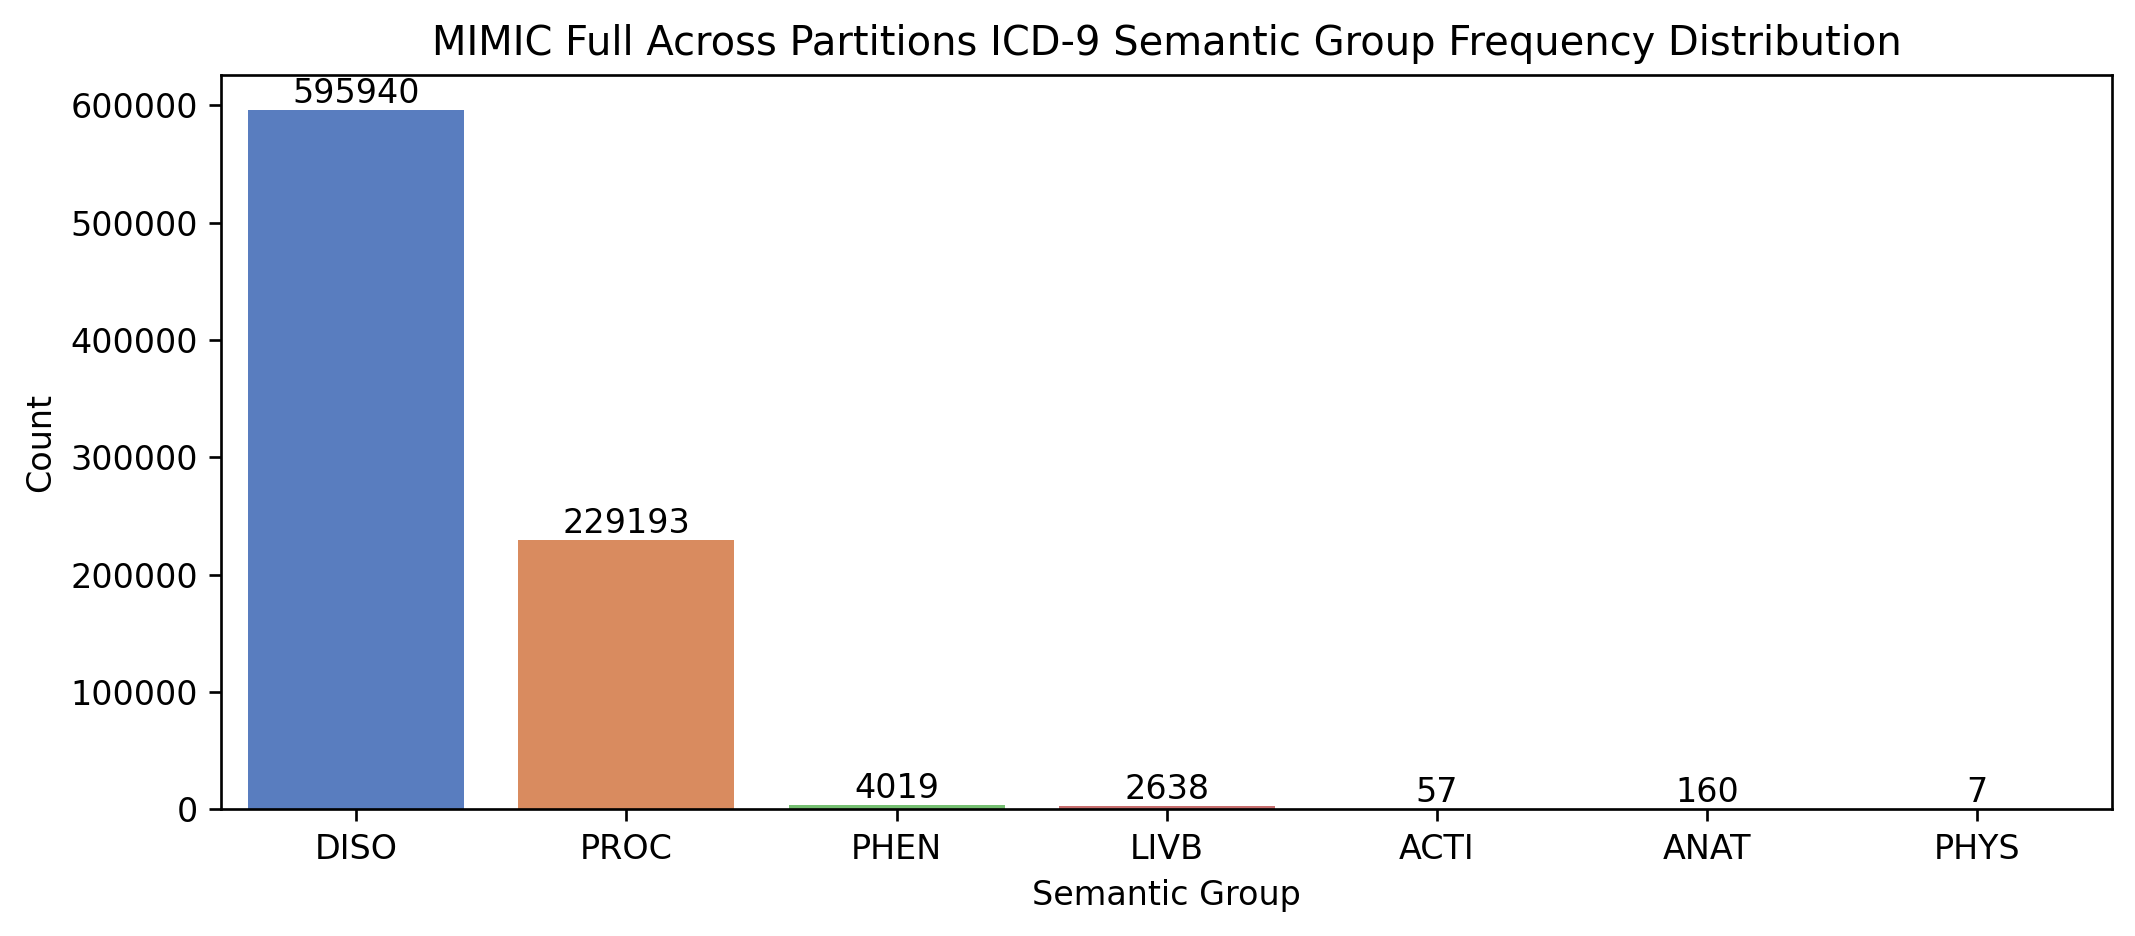

In [32]:
plt.figure(figsize=(9,4), dpi=240)
ax = sns.barplot(y=list(full_all_sg.values()), x=list(full_all_sg.keys()),palette="muted")
plt.xlabel(f"Semantic Group")
plt.ylabel(f"Count")
plt.title(f"MIMIC Full Across Partitions ICD-9 Semantic Group Frequency Distribution")
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()